In [10]:
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
import nltk
from keras.preprocessing import text, sequence
from sklearn.metrics import classification_report,confusion_matrix,accuracy_score
from sklearn.model_selection import train_test_split
import keras
from keras.models import Sequential
from keras.layers import Dense,Embedding,LSTM,Dropout,Bidirectional,GRU
import tensorflow as tf
from SentimentAnaylsisUtility import SentimentAnaylsisUtility
import pickle
from tqdm._tqdm_notebook import tqdm_notebook
from tqdm import tqdm
from sklearn.metrics import classification_report,confusion_matrix,accuracy_score
from sklearn.model_selection import train_test_split
tqdm_notebook.pandas()
from nltk.tokenize import word_tokenize
import nltk
import pickle
from nltk import corpus
from sklearn.metrics import precision_recall_fscore_support as score
from sklearn.metrics import accuracy_score
utility = SentimentAnaylsisUtility()

<Figure size 1152x504 with 0 Axes>

In [2]:
%%time
import re
def remove_URL(text):
    url = re.compile(r"https?://\S+|www\.\S+")
    return url.sub(r"", text)


def remove_html(text):
    html = re.compile(r"<.*?>")
    return html.sub(r"", text)

def create_corpus_tk(df):
    corpus = []
    for text in train_df["headline"]:
        words = [word.lower() for word in word_tokenize(text)]
        corpus.append(words)
    return corpus

def get_weight_matrix(model, vocab):
    vocab_size = len(vocab) + 1
    weight_matrix = np.zeros((vocab_size, EMBEDDING_DIM))
    for word, i in vocab.items():
        weight_matrix[i] = model[word]
    return weight_matrix

def getConfusionMatrixScore(y_test,y_pred):
    cm = confusion_matrix(y_test,y_pred)
    TN = cm[0][0]
    FN = cm[1][0]
    TP = cm[1][1]
    FP = cm[0][1]
    sensitivity  = TP / (TP+FN)
    specificity  = TN / (TN+FP)
    pos_pred_val = TP/ (TP+FP)
    neg_pred_val = TN/ (TN+FN)
    return round(sensitivity,3),round(specificity,3),round(pos_pred_val,3),round(neg_pred_val,3)

Wall time: 0 ns



Wall time: 588 ms


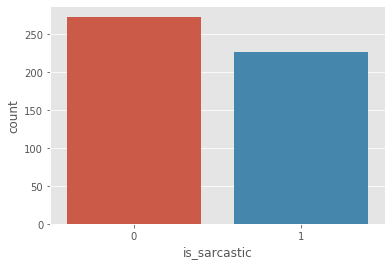

In [3]:
%%time
train_df = pd.read_json("Sarcasm_Headlines_Dataset_v2.json", lines=True)
train_df=train_df[:500]
train_df.drop(columns='article_link',inplace=True)
train_df['headline'] = train_df['headline'].progress_apply(lambda x:utility.remove_URL(x))
train_df['headline'] = train_df['headline'].progress_apply(lambda x:utility.remove_html(x))
train_df['headline'] = train_df['headline'].progress_apply(lambda x:utility.spacy_pre_processing(x))
sns.countplot(train_df.is_sarcastic)
    
scoringDF = pd.DataFrame(columns = ['Model', 'Accuracy', 'Precision','Recall','Fscore','Sensitivity','Specificity','Pos_pred_val','Neg_pred_val']) 
  

In [4]:
%%time
x_train,x_test,y_train,y_test = train_test_split(train_df.headline,train_df.is_sarcastic, test_size = 0.3 , random_state = 0)
max_features = 35000
maxlen = 200
tokenizer = text.Tokenizer(num_words=max_features)
tokenizer.fit_on_texts(x_train)
tokenized_train = tokenizer.texts_to_sequences(x_train)
x_train = sequence.pad_sequences(tokenized_train, maxlen=maxlen)
tokenized_test = tokenizer.texts_to_sequences(x_test)
x_test = sequence.pad_sequences(tokenized_test, maxlen=maxlen)
word_index = tokenizer.word_index
corpus = create_corpus_tk(train_df)
num_words = len(corpus)

embedding_dict = {}
with open("glove.twitter.27B.100d.txt", encoding="utf-8") as f:
    for line in f:
        values = line.split()
        word = values[0]
        vectors = np.asarray(values[1:], "float32")
        embedding_dict[word] = vectors
f.close()

num_words = len(word_index) + 1
embedding_matrix = np.zeros((num_words, 100))

for word, i in word_index.items():
    if i < num_words:
        emb_vec = embedding_dict.get(word)
        if emb_vec is not None:
            embedding_matrix[i] = emb_vec

Wall time: 1min 14s


In [5]:
%%time
batch_size = 128
epochs = 10
embed_size = 100
glove_model = Sequential()
glove_model.add(Embedding(num_words, output_dim=embed_size, weights=[embedding_matrix], input_length=maxlen, trainable=True))
glove_model.add(Bidirectional(LSTM(units=128 , recurrent_dropout = 0.3 , dropout = 0.3,return_sequences = True)))
glove_model.add(Bidirectional(GRU(units=32 , recurrent_dropout = 0.1 , dropout = 0.1)))
glove_model.add(Dense(1, activation='sigmoid'))
glove_model.compile(optimizer=keras.optimizers.Adam(lr = 0.01), loss='binary_crossentropy', metrics=['acc'])
glove_model.summary()

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
embedding (Embedding)        (None, 200, 100)          185200    
_________________________________________________________________
bidirectional (Bidirectional (None, 200, 256)          234496    
_________________________________________________________________
bidirectional_1 (Bidirection (None, 64)                55680     
_________________________________________________________________
dense (Dense)                (None, 1)                 65        
Total params: 475,441
Trainable params: 475,441
Non-trainable params: 0
_________________________________________________________________
Wall time: 645 ms


In [6]:
%%time
history = glove_model.fit(x_train, y_train, batch_size = batch_size , validation_data = (x_test,y_test) , epochs = epochs)

Epoch 1/10
3/3 [==============================] - 42s 10s/step - loss: 0.7251 - acc: 0.5440 - val_loss: 0.6482 - val_acc: 0.6133
Epoch 2/10
3/3 [==============================] - 22s 8s/step - loss: 0.5845 - acc: 0.7128 - val_loss: 0.6361 - val_acc: 0.6467
Epoch 3/10
3/3 [==============================] - 22s 8s/step - loss: 0.5366 - acc: 0.7601 - val_loss: 0.7342 - val_acc: 0.6133
Epoch 4/10
3/3 [==============================] - 23s 8s/step - loss: 0.2855 - acc: 0.9088 - val_loss: 0.7538 - val_acc: 0.6467
Epoch 5/10
3/3 [==============================] - 24s 8s/step - loss: 0.1597 - acc: 0.9473 - val_loss: 0.8305 - val_acc: 0.6667
Epoch 6/10
3/3 [==============================] - 24s 7s/step - loss: 0.0555 - acc: 0.9874 - val_loss: 0.9354 - val_acc: 0.6533
Epoch 7/10
3/3 [==============================] - 18s 6s/step - loss: 0.0231 - acc: 0.9962 - val_loss: 1.2244 - val_acc: 0.6667
Epoch 8/10
3/3 [==============================] - 16s 6s/step - loss: 0.0119 - acc: 0.9976 - val_loss: 

In [7]:
y_pred = glove_model.predict_classes(x_test)
print(classification_report(y_test, y_pred, target_names = ['Not Sarcastic','Sarcastic']))

               precision    recall  f1-score   support

Not Sarcastic       0.67      0.78      0.72        80
    Sarcastic       0.69      0.57      0.62        70

     accuracy                           0.68       150
    macro avg       0.68      0.67      0.67       150
 weighted avg       0.68      0.68      0.68       150



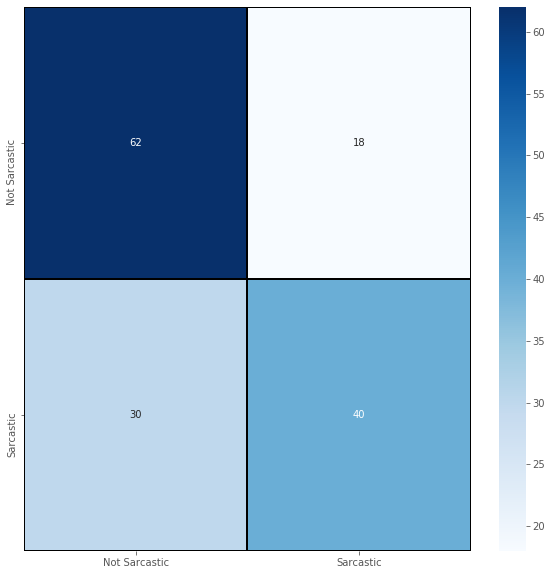

In [8]:
cm = confusion_matrix(y_test,y_pred)
cm = pd.DataFrame(cm , index = ['Not Sarcastic','Sarcastic'] , columns = ['Not Sarcastic','Sarcastic'])
plt.figure(figsize = (10,10))
sns.heatmap(cm,cmap= "Blues", linecolor = 'black' , linewidth = 1 , annot = True, fmt='' , xticklabels = ['Not Sarcastic','Sarcastic'] , yticklabels = ['Not Sarcastic','Sarcastic'])

In [11]:
precision,recall,fscore,support=score(y_test,y_pred,average='macro')
sensitivity,specificity,pos_pred_val,neg_pred_val = getConfusionMatrixScore(y_test,y_pred)
accuracy = accuracy_score(y_test, y_pred)
scoringDF = scoringDF.append({'Model' : "GloVe Model",'Accuracy' : accuracy,
                'Precision' : precision,'Recall' : recall,'Fscore' : fscore,'Sensitivity' : sensitivity,
                'Specificity' : specificity,'Pos_pred_val' : pos_pred_val,'Neg_pred_val' : neg_pred_val},ignore_index=True) 

In [16]:
%%time
words = []
for i in train_df.headline.values:
    words.append(i.split())

import gensim
maxlen = 200
EMBEDDING_DIM = 100
epochs = 10
w2v_model = gensim.models.Word2Vec(sentences = words , size=EMBEDDING_DIM , window = 5 , min_count = 1)
tokenizer = text.Tokenizer(num_words=35000)
tokenizer.fit_on_texts(words)
tokenized_train = tokenizer.texts_to_sequences(words)
x = sequence.pad_sequences(tokenized_train, maxlen)
vocab_size = len(tokenizer.word_index) + 1

Wall time: 1.46 s


In [17]:
%%time
word2Vec_model = Sequential()
embedding_vectors = get_weight_matrix(w2v_model, tokenizer.word_index)
#Non-trainable embeddidng layer
word2Vec_model.add(Embedding(vocab_size, output_dim=EMBEDDING_DIM, weights=[embedding_vectors], input_length=maxlen, trainable=True))
#LSTM 
word2Vec_model.add(Bidirectional(LSTM(units=128 , recurrent_dropout = 0.3 , dropout = 0.3,return_sequences = True)))
word2Vec_model.add(Bidirectional(GRU(units=32 , recurrent_dropout = 0.1 , dropout = 0.1)))
word2Vec_model.add(Dense(1, activation='sigmoid'))
word2Vec_model.compile(optimizer=keras.optimizers.Adam(lr = 0.01), loss='binary_crossentropy', metrics=['acc'])

del embedding_vectors
word2Vec_model.summary()

Model: "sequential_3"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
embedding_1 (Embedding)      (None, 200, 100)          245800    
_________________________________________________________________
bidirectional_2 (Bidirection (None, 200, 256)          234496    
_________________________________________________________________
bidirectional_3 (Bidirection (None, 64)                55680     
_________________________________________________________________
dense_1 (Dense)              (None, 1)                 65        
Total params: 536,041
Trainable params: 536,041
Non-trainable params: 0
_________________________________________________________________
Wall time: 834 ms


In [ ]:
%%time
x_train, x_test, y_train, y_test = train_test_split(x, train_df.is_sarcastic , test_size = 0.3 , random_state = 0)
word2Vec_model_history = word2Vec_model.fit(x_train, y_train, batch_size = 128 , validation_data = (x_test,y_test) , epochs = epochs)

Epoch 1/10
1/3 [=========>....................] - ETA: 51s - loss: 0.6932 - acc: 0.4297

In [ ]:
y_pred = word2Vec_model.predict_classes(x_test)
print(classification_report(y_test, pred, target_names = ['Not Sarcastic','Sarcastic']))

In [ ]:
cm = confusion_matrix(y_test,y_pred)
cm = pd.DataFrame(cm , index = ['Not Sarcastic','Sarcastic'] , columns = ['Not Sarcastic','Sarcastic'])
plt.figure(figsize = (10,10))
sns.heatmap(cm,cmap= "Blues", linecolor = 'black' , linewidth = 1 , annot = True, fmt='' , xticklabels = ['Not Sarcastic','Sarcastic'] , yticklabels = ['Not Sarcastic','Sarcastic'])

In [ ]:
precision,recall,fscore,support=score(y_test,y_pred,average='macro')
sensitivity,specificity,pos_pred_val,neg_pred_val = getConfusionMatrixScore(y_test,y_pred)
accuracy = accuracy_score(y_test, y_pred)
scoringDF = scoringDF.append({'Model' : "Word2Vec Model",'Accuracy' : accuracy,
                'Precision' : precision,'Recall' : recall,'Fscore' : fscore,'Sensitivity' : sensitivity,
                'Specificity' : specificity,'Pos_pred_val' : pos_pred_val,'Neg_pred_val' : neg_pred_val},ignore_index=True) 

In [ ]:
from keras.models import load_model 
word2Vec_model.save("SarcasmDetectionWord2VecModel.h5") 
loaded_word2Vec_model = load_model("SarcasmDetectionWord2VecModel.h5") 

In [ ]:
glove_model.save("SarcasmDetectionGloveModel.h5") 
loaded_glove_model = load_model("SarcasmDetectionGloveModel.h5") 

In [ ]:
pickl = {
    'tokenizer': tokenizer,
}
pickle.dump( pickl, open( 'SarcasmDectectionTokenizer' + ".pickle", "wb" ) )

In [ ]:
scoringDF
scoringDF.style.highlight_max(color = 'pink', axis = 0)